In [8]:
import math
import random
import matplotlib.pyplot as plt

In [10]:
# -------------------------------
# TELEGRAPH MODEL (Two-state gene expression)
# -------------------------------
def simulate_telegraph_model(a, b, q, d, T_max):
    """
    Simulate the telegraph model of gene expression using the Gillespie algorithm.
    
    Parameters:
      a   : mRNA production rate (when promoter is ON)
      b   : Promoter activation rate (GOFF -> GON)
      q   : Promoter inactivation rate (GON -> GOFF)
      d   : mRNA degradation rate (per mRNA molecule)
      T_max: Maximum simulation time
      
    Returns:
      A list of tuples (t, promoter_state, mRNA_count)
      where promoter_state is 1 for ON and 0 for OFF.
    """
    t = 0.0
    promoter_state = 0  # 0: OFF, 1: ON
    mRNA = 0
    traj = [(t, promoter_state, mRNA)]
    
    while t < T_max:
        reactions = []
        rates = []
        # Reaction 1: Promoter activation (only if OFF)
        if promoter_state == 0:
            reactions.append("activate")
            rates.append(b)
        # Reaction 2: Promoter inactivation (only if ON)
        if promoter_state == 1:
            reactions.append("inactivate")
            rates.append(q)
        # Reaction 3: mRNA production (only if promoter is ON)
        if promoter_state == 1:
            reactions.append("production")
            rates.append(a)
        # Reaction 4: mRNA degradation (if any mRNA exist)
        if mRNA > 0:
            reactions.append("degradation")
            rates.append(d * mRNA)
        
        a_total = sum(rates)
        if a_total <= 0:
            break
        
        # Sample time until next reaction
        r1 = random.random()
        dt = -math.log(r1) / a_total
        t += dt
        
        # Determine which reaction occurs
        r2 = random.random() * a_total
        cumulative = 0.0
        for reaction, rate in zip(reactions, rates):
            cumulative += rate
            if cumulative >= r2:
                chosen_reaction = reaction
                break
        
        # Update the system state
        if chosen_reaction == "activate":
            promoter_state = 1
        elif chosen_reaction == "inactivate":
            promoter_state = 0
        elif chosen_reaction == "production":
            mRNA += 1
        elif chosen_reaction == "degradation":
            mRNA -= 1
        
        traj.append((t, promoter_state, mRNA))
    
    return traj


In [12]:
# -------------------------------
# TRANSCRIPTION-COUPLED REPAIR (TCR) MODEL
# -------------------------------
def simulate_tcr_model(gene_length, k, P_d, P_r, P_v, lesion_prob):
    """
    Simulate a simplified TCR model where an RNA polymerase transcribes a gene with random lesions.
    
    Parameters:
      gene_length: Length of the gene (number of positions)
      k         : Elongation rate (per step)
      P_d       : Probability of detecting a visible lesion
      P_r       : Probability of restarting transcription after repair
      P_v       : Probability that a lesion is visible to TCR
      lesion_prob: Probability that any given nucleotide is damaged (i.e. a lesion exists)
      
    Returns:
      A trajectory list of tuples (t, position, event)
      where 'event' is a string describing what happened at that time.
      (For steps without a special event, event is 'elongation'.)
    """
    t = 0.0
    position = 0
    traj = [(t, position, "start")]
    
    # Simulate until the polymerase reaches the end or dissociates.
    while position < gene_length - 1:
        # Check if the next position has a lesion.
        lesion_here = (random.random() < lesion_prob)
        
        if not lesion_here:
            # No lesion: Only one reaction (elongation) is possible.
            rate = k
            dt = -math.log(random.random()) / rate
            t += dt
            position += 1
            traj.append((t, position, "elongation"))
        else:
            # There is a lesion. Determine if the lesion is visible.
            visible = (random.random() < P_v)
            if not visible:
                # Invisible lesion: treat as normal elongation.
                rate = k
                dt = -math.log(random.random()) / rate
                t += dt
                position += 1
                traj.append((t, position, "invisible lesion - elongation"))
            else:
                # Visible lesion: set up multiple reaction channels.
                # Reaction channels:
                # 1. Detection, repair, and restart (polymerase remains at same position)
                # 2. Detection, repair failure (polymerase dissociates)
                # 3. No detection (polymerase passes the lesion, advances)
                a1 = k * P_d * P_r            # repair and restart
                a2 = k * P_d * (1 - P_r)        # dissociation after detection/repair failure
                a3 = k * (1 - P_d)              # not detected: passes lesion
                a_total = a1 + a2 + a3
                dt = -math.log(random.random()) / a_total
                t += dt
                r = random.random() * a_total
                if r < a1:
                    # Repair and restart: RNAP remains at the same position (can try again).
                    traj.append((t, position, "visible lesion - repair & restart"))
                elif r < a1 + a2:
                    # Dissociation: transcription stops.
                    traj.append((t, position, "visible lesion - dissociation"))
                    break
                else:
                    # Pass the lesion: RNAP advances to the next position.
                    position += 1
                    traj.append((t, position, "visible lesion - passed"))
    return traj

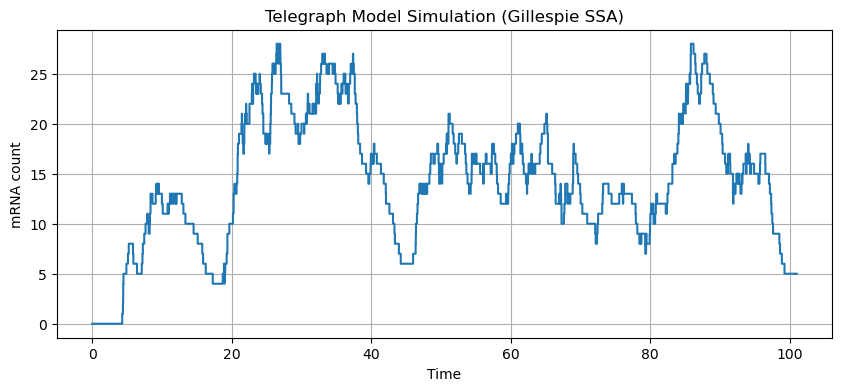

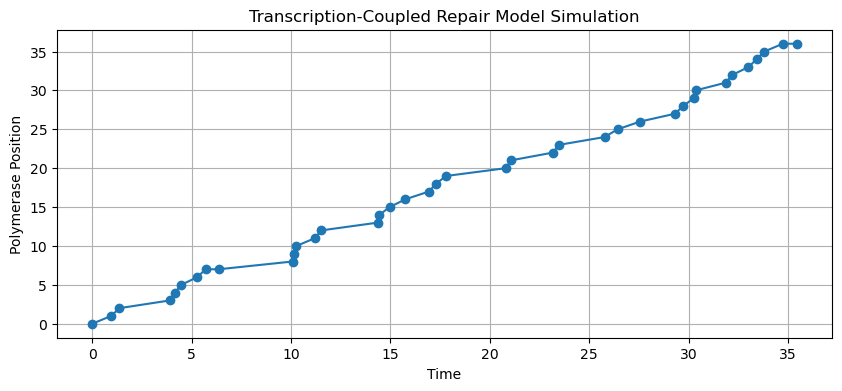

Time: 0.00, Position: 0, Event: start
Time: 0.95, Position: 1, Event: elongation
Time: 1.37, Position: 2, Event: elongation
Time: 3.92, Position: 3, Event: elongation
Time: 4.16, Position: 4, Event: elongation
Time: 4.48, Position: 5, Event: elongation
Time: 5.29, Position: 6, Event: elongation
Time: 5.70, Position: 7, Event: elongation
Time: 6.35, Position: 7, Event: visible lesion - repair & restart
Time: 10.08, Position: 8, Event: elongation
Time: 10.17, Position: 9, Event: elongation
Time: 10.27, Position: 10, Event: elongation
Time: 11.20, Position: 11, Event: elongation
Time: 11.52, Position: 12, Event: elongation
Time: 14.37, Position: 13, Event: elongation
Time: 14.45, Position: 14, Event: elongation
Time: 14.96, Position: 15, Event: elongation
Time: 15.75, Position: 16, Event: elongation
Time: 16.94, Position: 17, Event: elongation
Time: 17.29, Position: 18, Event: elongation
Time: 17.81, Position: 19, Event: elongation
Time: 20.81, Position: 20, Event: elongation
Time: 21.05,

In [16]:
# -------------------------------
# MAIN: Run Simulations and Plot Results
# -------------------------------
if __name__ == "__main__":
    # Parameters for the telegraph model
    a = 5.0      # mRNA production rate
    b = 0.5      # Promoter activation rate
    q = 0.5      # Promoter inactivation rate
    d = 0.2      # mRNA degradation rate
    T_max = 100   # Simulation time
    
    telegraph_traj = simulate_telegraph_model(a, b, q, d, T_max)
    
    # Extract time and mRNA count for plotting
    t_vals = [pt[0] for pt in telegraph_traj]
    mRNA_vals = [pt[2] for pt in telegraph_traj]
    
    plt.figure(figsize=(10, 4))
    plt.step(t_vals, mRNA_vals, where='post')
    plt.xlabel('Time')
    plt.ylabel('mRNA count')
    plt.title('Telegraph Model Simulation (Gillespie SSA)')
    plt.grid(True)
    plt.show()
    
    # Parameters for the transcription-coupled repair model
    gene_length = 100   # gene length in nucleotides
    k = 1.0             # elongation rate per step
    P_d = 0.8           # probability of detecting a visible lesion
    P_r = 0.5           # probability of restarting transcription after repair
    P_v = 0.7           # probability that a lesion is visible to TCR
    lesion_prob = 0.1   # probability that any nucleotide is a lesion
    
    tcr_traj = simulate_tcr_model(gene_length, k, P_d, P_r, P_v, lesion_prob)
    
    # Plot the trajectory for the TCR model:
    positions = [pt[1] for pt in tcr_traj]
    times = [pt[0] for pt in tcr_traj]
    events = [pt[2] for pt in tcr_traj]
    
    plt.figure(figsize=(10, 4))
    plt.plot(times, positions, marker='o')
    plt.xlabel('Time')
    plt.ylabel('Polymerase Position')
    plt.title('Transcription-Coupled Repair Model Simulation')
    plt.grid(True)
    plt.show()
    
    # Optional: print events to see what happened during the simulation
    for event in tcr_traj:
        print("Time: {:.2f}, Position: {}, Event: {}".format(event[0], event[1], event[2]))
